In [200]:
import getpass
import os
import random
import re
import tarfile
import time

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.utils as utils
import torchvision.transforms as transforms
import pandas as pd

### Split dataset
Use 80% (283 images) of data to train and 20% (71) to validate. (originally 285 in train but 2 are hands)

In [201]:
import os
import random
import shutil

# Define the paths
source_folder = 'images'
train_folder = os.path.join(source_folder, 'train')
val_folder = os.path.join(source_folder, 'val')

# Create train and val folders if they do not exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

# Get all image files in the source folder
all_images = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]


# Shuffle the list of images
random.shuffle(all_images)

# Select images for train and val
train_images = all_images[:285]
val_images = all_images[285:356]

# Move images to the train folder
for img in train_images:
    shutil.move(os.path.join(source_folder, img), os.path.join(train_folder, img))

# Move images to the val folder
for img in val_images:
    shutil.move(os.path.join(source_folder, img), os.path.join(val_folder, img))

print("Images have been successfully moved to 'train' and 'val' folders.")


Images have been successfully moved to 'train' and 'val' folders.


Note: when defining the classes, the labels must be in the same order as the folders in images!

In [202]:
# Define the paths for train and validation directories
train_dir =  'images/train'
valid_dir = 'images/val'

#name of the classes
classes = ("0.1CHF", "0.1EUR", "0.01EUR", "0.2CHF", "0.2EUR", "0.2EUR", "0.5CHF", "0.05CHF", "0.5EUR", "0.05EUR", "1CHF", "1EUR", "2CHF", "2EUR", "5CHF", "OOD")
NUM_CLASSES = len(classes) 
assert(NUM_CLASSES==16)
# batch size
batch_size = 10

## ImageFolder
ImageFolder uses directory structure to determine the class labels.
So we will have the following structure: (manually classified)

```text
images/
|-- train/
|   |-- 0.1CHF/
|   |   |-- ....JPG
|   |   |-- ....jpg
|   |   |-- ...
|   |-- 0.1EUR/
|   |   |-- ....JPG
|   |   |-- ....JPG
|   |   |-- ....JPG
|
|-- val/
|   |-- 0.1CHF/
|   |   |-- ....JPG
|   |   |-- ....JPG
|   |   |-- ...
|   |-- 0.1EUR/
|   |   |-- ....JPG
|   |   |-- ....JPG
|   |   |-- ...
```
Note: some coins are more dicy to classify, i.e. the tale CHF coins which are very similar, we thus need to measure the diameter of the coins. Luckily all our images have the same dimensions.
Note also that two images were removed from the train folder (hands with hairs on them)

## Preprocessing and ensuring mapping is correct

In [189]:
# Adaptation of the code from Lab2
# mean and std for normalisation are chosen based on ImageNet statistics
'''
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

train_set = datasets.ImageFolder(train_dir, transform)
valid_set = datasets.ImageFolder(valid_dir, transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)
'''


ValueError: num must be 1 <= num <= 30, not 31

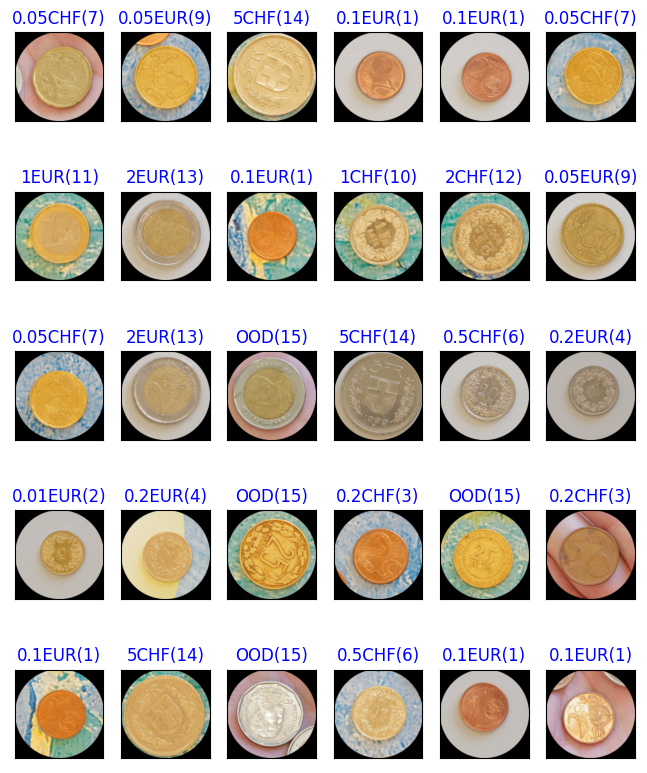

In [203]:
# Visualization of images

# get some random training images
# a quick explanation of iter() and next():
# https://stackoverflow.com/questions/62549990/what-does-next-and-iter-do-in-pytorchs-dataloader


def plot_images_from_dataset(images, labels):
    batch_size = images.shape[0]
    fig = plt.figure(figsize=(8, 10))
    for idx in np.arange(int(batch_size)):
        ax = fig.add_subplot(5, int(batch_size/5), idx+1, xticks=[], yticks=[])
        img = np.squeeze(images[idx])
        # revert normalisation
        img = img * np.expand_dims(np.array([0.229, 0.224, 0.225]), (1, 2)) + np.expand_dims(np.array([0.485, 0.456, 0.406]), (1, 2))
        img = np.clip(img, 0, 1)
        plt.imshow(np.transpose(img, (1,2,0)))
        ax.set_title("{}({})".format(classes[labels[idx]],str(labels[idx].item())),
                    color=("blue"))

dataiter = iter(train_loader) #iter() returns an iterator
images, labels = next(dataiter) # call next() on the iterator to get the first iteration

plot_images_from_dataset(images, labels)

As we see the mapping is off => make our own custome mapping, same order as directory folders!

Visualize if mapping is correct

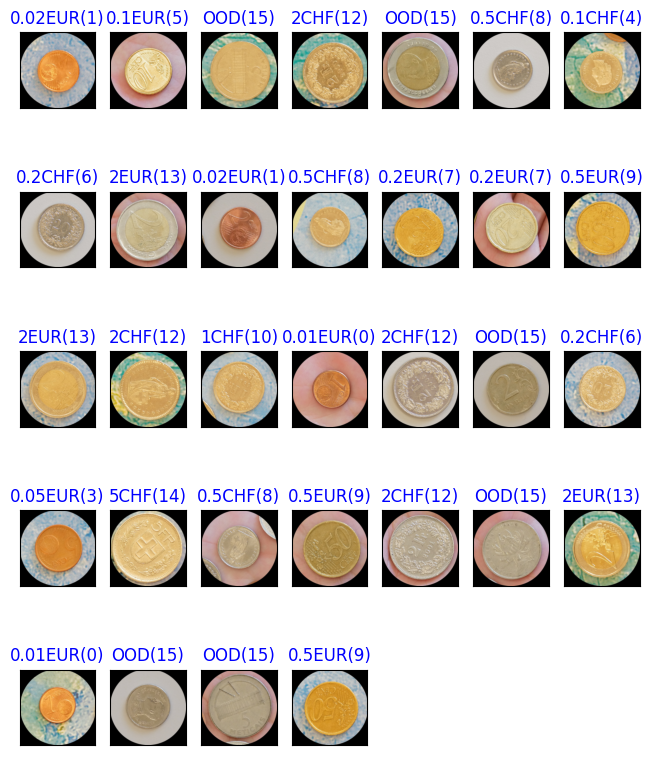

In [204]:
# Define custom mapping
custom_mapping = {
    '0.1CHF': 0,
    '0.1EUR': 1,
    '0.01EUR': 2,
    '0.2CHF': 3,
    '0.2EUR': 4,
    '0.02EUR': 5,
    '0.5CHF': 6,
    '0.05CHF': 7,
    '0.5EUR': 8,
    '0.05EUR': 9,
    '1CHF': 10,
    '1EUR': 11,
    '2CHF': 12,
    '2EUR': 13,
    '5CHF': 14,
    'OOD': 15
}

# Define transformations
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

transform = transforms.Compose([
    #transforms.Resize(224),
    #transforms.CenterCrop(224),
    #transforms.ToTensor(),
    #normalize,
])

# Create dataset with custom mapping
#train_set = datasets.ImageFolder(train_dir, transform=transform)
#valid_set = datasets.ImageFolder(valid_dir, transform=transform)

# Override the class_to_idx mapping with the custom mapping
train_set.class_to_idx = custom_mapping
valid_set.class_to_idx = custom_mapping

# Create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

# Define a function to plot images from the dataset
def plot_images_from_dataset(images, labels, classes):
    batch_size = images.shape[0]
    rows = 5
    cols = (batch_size + rows - 1) // rows  # Calculate the number of columns dynamically
    fig = plt.figure(figsize=(8, 2 * rows))  # Adjust figure size based on rows
    for idx in range(batch_size):
        ax = fig.add_subplot(rows, cols, idx+1, xticks=[], yticks=[])
        img = np.squeeze(images[idx])
        # Revert normalization
        img = img * np.expand_dims(np.array([0.229, 0.224, 0.225]), (1, 2)) + np.expand_dims(np.array([0.485, 0.456, 0.406]), (1, 2))
        img = np.clip(img, 0, 1)
        plt.imshow(np.transpose(img, (1,2,0)))
        ax.set_title("{}({})".format(classes[labels[idx]], str(labels[idx].item())), color=("blue"))

# Get a batch of images and labels from the train loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot the images
plot_images_from_dataset(images, labels, train_set.classes)

## Visualize class distribution

how many images in the train set:  283


No handles with labels found to put in legend.


images per class in dataloader:  {'OOD': 28, '0.1CHF': 14, '0.05EUR': 27, '2EUR': 24, '0.01EUR': 13, '0.2CHF': 23, '2CHF': 19, '0.05CHF': 23, '0.2EUR': 25, '1CHF': 16, '0.1EUR': 18, '5CHF': 22, '1EUR': 8, '0.5CHF': 8, '0.5EUR': 15}


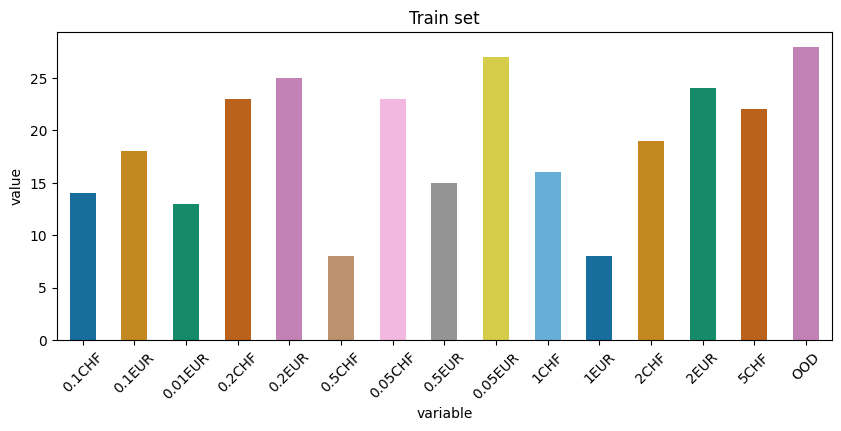

In [205]:
# class distribution
import seaborn as sns
from collections import Counter

print("how many images in the train set: ", len(train_set.targets))

# later in this exercise you will explore the ways to rebalance the data in the dataloader
# Recall from Lab2 how to visualise the distributions of the images in the dataloader
def plot_class_distribution_for_dataloader(dataloader):
# count how many images are outputted by dataloader per class
    count_dict = {}
    for _, target in dataloader:
        for t in target:
            t = classes[int(t)]
            if t not in count_dict:
                count_dict[t] = 0
            count_dict[t] += 1
    print("images per class in dataloader: ", count_dict)
    plt.figure(figsize=(10, 4))
    #plot the class ditribution
    sns.barplot(data=pd.DataFrame.from_dict([count_dict])[list(classes)].melt(),
                  x="variable", y="value", hue="variable", palette="colorblind", width = 0.5,  dodge=False)

    plt.title("Train set")
    plt.xticks(rotation=45)
    plt.legend().set_visible(False)
    plt.show()

plot_class_distribution_for_dataloader(train_loader)
## the training set is perfectly balanced: same number of image for all classes

In the plot above we visualize the class distribution.

## Define metrics: accuracy and f1score

In [206]:
from sklearn.metrics import f1_score, accuracy_score
def f1(preds, target):
    return f1_score(target, preds, average='macro')

def acc(preds, target):
    return accuracy_score(target, preds)

## Define Model

In [207]:
import torchvision.models as models

In [208]:
class CoinNet(nn.Module):
    def __init__(self, weights=None):
        super().__init__()
        # Loading AlexNet
        self.model = models.alexnet(pretrained=True)
        # Changing the last layers
        # to reduce the computational complexity we reduce the size of hidden layers
        self.model.classifier[1] = nn.Linear(9216, 64)
        self.model.classifier[4] = nn.Linear(64, 32)
        self.model.classifier[6] = nn.Linear(32, 16)

    def freeze_feature_layers(self):
        # Freeze the feature extraction part
        for param in self.model.features:
            param.requires_grad_(False)

    def forward(self, x):
        return self.model(x)

In [209]:
##
from tqdm import tqdm #to see the progress of training
from IPython.display import clear_output



def train_epoch(model, optimizer, criterion, metrics, train_loader, device):
    '''
    device = torch.device('cuda') or torch.device('cpu') if no GPU available
    '''
    model.train()
    epoch_loss = 0
    epoch_metrics = dict(zip(metrics.keys(), torch.zeros(len(metrics))))

    for batch_num, (x_batch, y_batch) in tqdm(enumerate(train_loader)):
        data = x_batch.to(device)
        target = y_batch.to(device)

        #clean previously computed gradients
        optimizer.zero_grad()

        # forward
        outputs = model(data)

        #compute predictions
        with torch.no_grad():
            _, preds = torch.max(outputs, 1)

        #compute loss
        loss = criterion(outputs, target)

        #do backward and oprimizer steps
        loss.backward()
        optimizer.step()

        # compute metrics
        # no gradients should be propagated at this step
        with torch.no_grad():
            for k in epoch_metrics.keys():
                epoch_metrics[k] += metrics[k](preds, target)


        # log loss statistics
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)

    for k in epoch_metrics.keys():
          epoch_metrics[k] /= len(train_loader)

    clear_output() #clean the prints from previous epochs
    print('train Loss: {:.4f}, '.format(epoch_loss),
          ', '.join(['{}: {:.4f}'.format(k, epoch_metrics[k]) for k in epoch_metrics.keys()]))

    return epoch_loss,  epoch_metrics

In [210]:
def evaluate(model, criterion, metrics, test_loader, device):
    model.eval()

    epoch_loss = 0
    epoch_metrics = dict(zip(metrics.keys(), torch.zeros(len(metrics))))

    for batch_num, (x_batch, y_batch) in enumerate(test_loader):
        with torch.no_grad(): # we don't compute gradients here
            data = x_batch.to(device)
            target = y_batch.to(device)

            #forward
            outputs = model(data)

            #compute loss
            loss = criterion(outputs, target)

            #compute predictions
            _, preds = torch.max(outputs, 1)

            # compute metrics
            for k in epoch_metrics.keys():
                epoch_metrics[k] += metrics[k](preds, target)

            # log loss statistics
            epoch_loss += loss.item()

    epoch_loss /= len(test_loader)

    for k in epoch_metrics.keys():
          epoch_metrics[k] /= len(test_loader)

    print('eval Loss: {:.4f}, '.format(epoch_loss),
          ', '.join(['{}: {:.4f}'.format(k, epoch_metrics[k]) for k in epoch_metrics.keys()]))

    return epoch_loss,  epoch_metrics

In [211]:
def plot_training(train_loss, test_loss, metrics_names, train_metrics_logs, test_metrics_logs):
    fig, ax = plt.subplots(1, len(metrics_names) + 1, figsize=((len(metrics_names) + 1) * 5, 5))

    ax[0].plot(train_loss, c='blue', label='train')
    ax[0].plot(test_loss, c='orange', label='test')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('epoch')
    ax[0].legend()

    for i in range(len(metrics_names)):
        ax[i + 1].plot(train_metrics_logs[i], c='blue', label='train')
        ax[i + 1].plot(test_metrics_logs[i], c='orange', label='test')
        ax[i + 1].set_title(metrics_names[i])
        ax[i + 1].set_xlabel('epoch')
        ax[i + 1].legend()

    plt.show()



In [212]:
#actually you have to use validation for each step of training, but now we will focus only on the toy example and will track the perfromance on test
def update_metrics_log(metrics_names, metrics_log, new_metrics_dict):
    for i in range(len(metrics_names)):
        curr_metric_name = metrics_names[i]
        metrics_log[i].append(new_metrics_dict[curr_metric_name])
    return metrics_log


def train_cycle(model, optimizer, criterion, metrics, train_loader, test_loader, n_epochs, device):
    train_loss_log,  test_loss_log = [], []
    metrics_names = list(metrics.keys())
    train_metrics_log = [[] for i in range(len(metrics))]
    test_metrics_log = [[] for i in range(len(metrics))]


    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss, train_metrics = train_epoch(model, optimizer, criterion, metrics, train_loader, device)

        test_loss, test_metrics = evaluate(model, criterion, metrics, test_loader, device)

        train_loss_log.append(train_loss)
        train_metrics_log = update_metrics_log(metrics_names, train_metrics_log, train_metrics)

        test_loss_log.append(test_loss)
        test_metrics_log = update_metrics_log(metrics_names, test_metrics_log, test_metrics)

        plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)
    return train_metrics_log, test_metrics_log


## Train NN without any data augmentation

train Loss: 0.7294,  ACC: 0.7288, F1-weighted: 0.6093
eval Loss: 1.0879,  ACC: 0.6741, F1-weighted: 0.4913


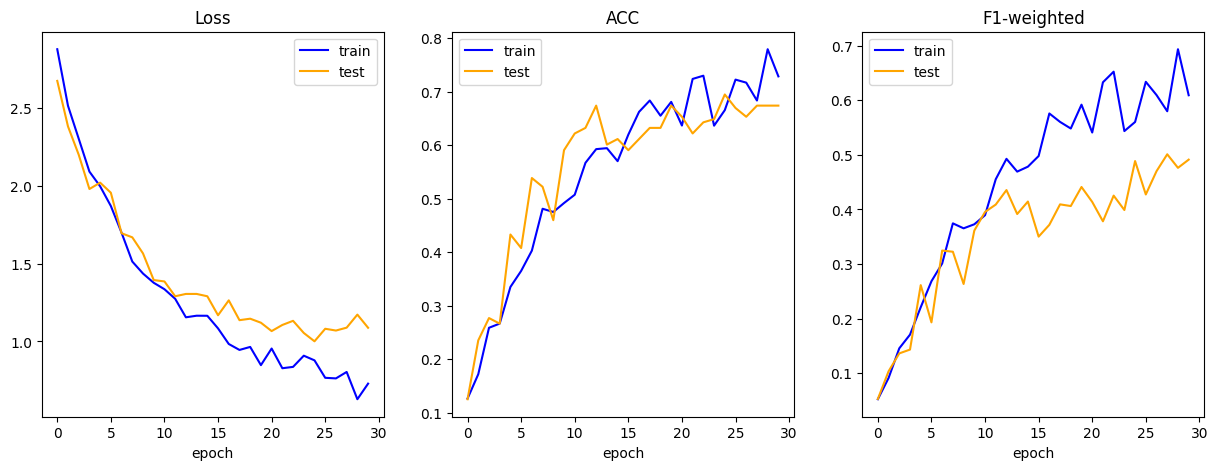

In [213]:
torch.manual_seed(42)

model = CoinNet(weights="IMAGENET1K_V1")
model.freeze_feature_layers()

learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
metrics = {'ACC': acc, 'F1-weighted': f1}
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

N_EPOCHS = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
# criterion.to(device)

train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, train_loader, valid_loader, n_epochs=N_EPOCHS, device=device)

# save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model.pth')


## Feature augmentation
We try: RGB, not good since the validation data has the same colors as the train
Scaling / croping: not a good idea since once again the coins have a fixed size and are whole

/opt/anaconda3/lib/python3.9/site-packages/torchvision/transforms/transforms.py:1200: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


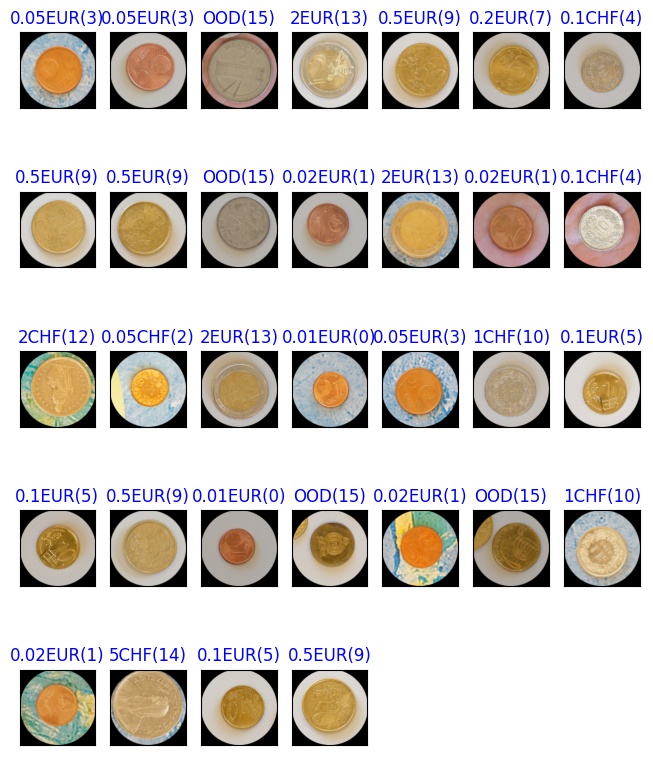

In [214]:
import PIL
from PIL import Image, ImageFilter
import torch
from torchvision import datasets, transforms
'''
# Define normalization
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
'''
# Define additional transformations including brightness/saturation, rotation, Gaussian blur, and contour enhancement
additional_transforms = transforms.Compose([
    transforms.RandomApply([transforms.ColorJitter(brightness=0.1, saturation=0.2)], p=1),  # Random brightness and saturation adjustments
    transforms.RandomApply([transforms.RandomRotation(degrees=(-30, 30), resample=Image.BILINEAR)], p=0.5),  # Random rotation
    transforms.RandomApply([transforms.Lambda(lambda x: x.filter(ImageFilter.GaussianBlur(radius=2)))], p=0.5),  # Gaussian blur
   # transforms.RandomApply([transforms.Lambda(lambda x: x.filter(ImageFilter.CONTOUR))], p=0.5),  # Contour enhancement
    transforms.RandomVerticalFlip(p=0.5),  # Random vertical flip
    transforms.RandomApply([transforms.Lambda(lambda x: x)], p=0.2)  # With 20% probability, keep the image as is
])

# Define the transformation pipeline for the training set
transform_train = transforms.Compose([
    additional_transforms,  # Apply additional transformations
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),  # Ensure resizing but keeping the original aspect ratio
    transforms.CenterCrop(224),  # Ensure center cropping without changing shape
    transforms.ToTensor(),
    normalize,
])

# Create the augmented training set
augmented_train_set = datasets.ImageFolder(train_dir, transform_train)
augmented_train_loader = torch.utils.data.DataLoader(augmented_train_set, batch_size=batch_size, shuffle=True)

# Plot augmented images
dataiter = iter(augmented_train_loader)
images, labels = next(dataiter)
classes = augmented_train_set.classes
plot_images_from_dataset(images, labels, classes)

# Validation set remains the same
transform_valid = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])
augmented_valid_set = datasets.ImageFolder(valid_dir, transform)
augmented_valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)


Combine both original and augmented data

In [179]:
combined_train_set = torch.utils.data.ConcatDataset([train_set, augmented_train_set])
combined_train_loader = torch.utils.data.DataLoader(combined_train_set, batch_size=batch_size, shuffle=True)
combined_val_set = torch.utils.data.ConcatDataset([valid_set, augmented_valid_set])
combined_val_loader = torch.utils.data.DataLoader(combined_val_set, batch_size=batch_size, shuffle=True)


train Loss: 0.9381,  ACC: 0.6360, F1-weighted: 0.5579
eval Loss: 1.1137,  ACC: 0.6741, F1-weighted: 0.4876


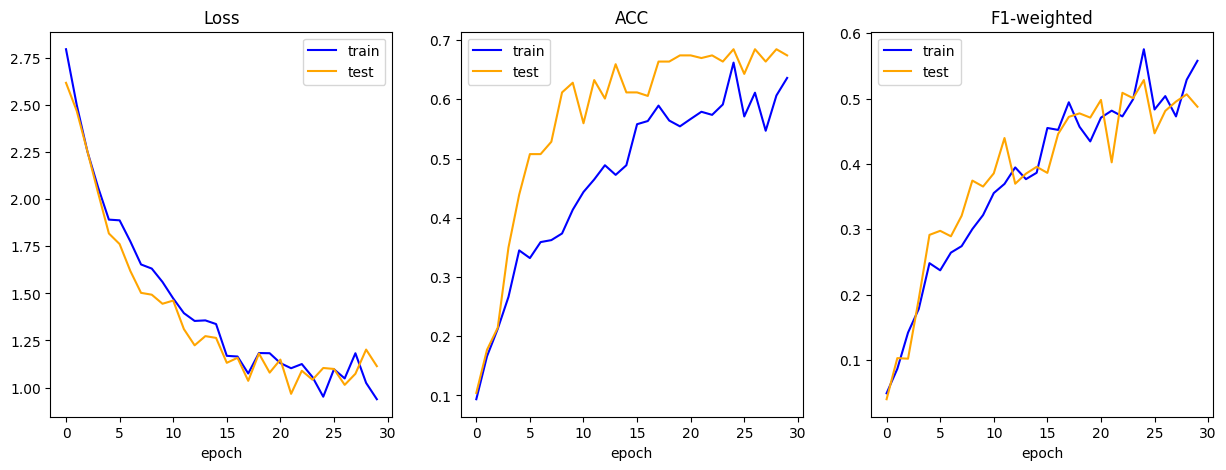

In [215]:
torch.manual_seed(42)

model = CoinNet(weights="IMAGENET1K_V1")
model.freeze_feature_layers()

learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
metrics = {'ACC': acc, 'F1-weighted': f1}
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train two more apochs in comparison to previous training
N_EPOCHS = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
# criterion.to(device)

train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, combined_train_loader, valid_loader, n_epochs=N_EPOCHS, device=device)

# save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model_trained_on_augmented_set.pth')

In [216]:
# Calculate the total number of images in the augmented training set
total_images = len(combined_train_set)

print("Total number of images after feature augmentation:", total_images)


Total number of images after feature augmentation: 566
